<a href="https://colab.research.google.com/github/wj-arit/VIT_implement/blob/main/VIT_compare_(cls%2Cgap).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import timm
from pprint import pprint
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


In [2]:

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# pprint(timm.list_models('*vit_base_patch16_224*', pretrained=True)) #불러올 모델 확인
# model = timm.create_model('vit_base_patch16_224.augreg_in21k',pretrained=True,num_classes=100) # 모델 불러오기 후에 사용

# # 모델의 기본 설정 정보 출력
# cfg = model.default_cfg
# print("사용 가능한 키:", cfg.keys())
# print(f"가중치 출처 (URL): {cfg.get('url', 'N/A')}")
# print(f"HuggingFace ID: {cfg.get('hf_hub_id', 'N/A')}")
# print(f"학습 설정 태그: {cfg.get('tag', 'N/A')}")
# print(f"이미지 전처리 사이즈: {cfg.get('input_size', 'N/A')}")
# print(f"보간법 (Interpolation): {cfg.get('interpolation', 'N/A')}")

['vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

사용 가능한 키: dict_keys(['url', 'hf_hub_id', 'architecture', 'tag', 'custom_load', 'input_size', 'fixed_input_size', 'interpolation', 'crop_pct', 'crop_mode', 'mean', 'std', 'num_classes', 'pool_size', 'first_conv', 'classifier', 'license'])
가중치 출처 (URL): https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0.npz
HuggingFace ID: timm/vit_base_patch16_224.augreg_in21k
학습 설정 태그: augreg_in21k
이미지 전처리 사이즈: (3, 224, 224)
보간법 (Interpolation): bicubic


100%|██████████| 169M/169M [00:08<00:00, 20.6MB/s]


50000
40000 10000 10000
<class 'torchvision.datasets.cifar.CIFAR100'> <class '__main__.ApplyTransform'>
torch.Size([3, 224, 224])
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plat

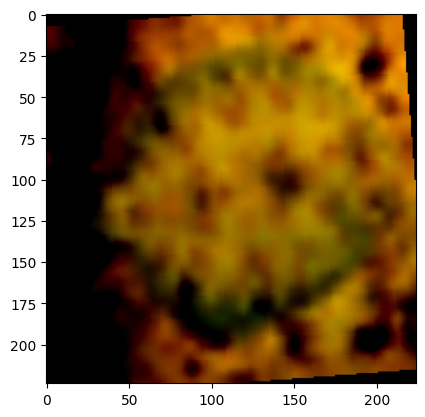

In [4]:
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)
# 학습 데이터 세팅
train_transform = transforms.Compose([
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])
# 밸리데이션 데이터 세팅
val_transform = transforms.Compose([
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])
# 테스트 데이터 세팅
test_transform = transforms.Compose([
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

full_train_dataset = datasets.CIFAR100(root='./data',train=True,transform=None,download=True)
test_dataset = datasets.CIFAR100(root='./data',train=False,transform=test_transform,download=True)

# 스플릿 비율고정
torch.manual_seed(42)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset)-train_size

# 스플릿
train_raw, val_raw = torch.utils.data.random_split(full_train_dataset,[train_size,val_size])
train_dataset = ApplyTransform(train_raw,transform=train_transform)
val_dataset = ApplyTransform(val_raw,transform=val_transform)

train_batch = 256
val_batch = 512
test_batch = 512
# 데이터 로더
train_DL = DataLoader(train_dataset,batch_size=train_batch,shuffle=True)
val_DL = DataLoader(val_dataset,batch_size=val_batch,shuffle=False)
test_DL = DataLoader(test_dataset,batch_size=test_batch,shuffle=False)

if __name__ == "__main__":
    print(len(full_train_dataset))
    print(train_size, val_size,len(test_dataset))
    print(type(test_dataset),type(train_dataset))
    x1,y1 = train_dataset[0]
    x2,y2 = val_dataset[0]
    print(x1.shape)
    print(full_train_dataset.class_to_idx)
    print(y1)
    plt.imshow(x1.permute(1,2,0))
    plt.show()

In [5]:
class VitCompare(nn.Module):
    def __init__(self,model_name,mode='cls',num_classes=100):
        super().__init__()
        # head 제거 백본 가져오기
        self.backbone = timm.create_model(model_name,pretrained=True,num_classes=0)
        self.mode = mode

        # head
        self.head = nn.Linear(self.backbone.num_features,num_classes)

        # 헤드 초기화
        self._init_weight()

    def _init_weight(self):
        nn.init.xavier_normal_(self.head.weight)
        if self.head.bias is not None:
            nn.init.constant_(self.head.bias,0)
    def forward(self,x):
        # timm 모듈로 헤드 전의 특징추출
        x = self.backbone.forward_features(x)

        if self.mode == 'cls':
            # 0번째인 cls 토큰 사용
            feat = x[:,0]
        elif self.mode == 'gap':
            # cls 제외 나머지 gap 사용
            feat = x[:,1:].mean(dim=1)
        out = self.head(feat)
        return out

In [12]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

model = 'vit_base_patch16_224.augreg_in21k'
model_cls = VitCompare(model,'cls',100).to(device)
model_gap = VitCompare(model,'gap',100).to(device)

criterion = nn.CrossEntropyLoss()

optimizer_cls = torch.optim.AdamW(model_cls.parameters(), lr=1e-4, weight_decay=0.05)
optimizer_gap = torch.optim.AdamW(model_gap.parameters(), lr=1e-4, weight_decay=0.05)

def train_one_epoch(my_model,train_dataloader,optimizer,criterion,device):
    my_model.train()
    total_correct = 0
    total_loss = 0.0
    total = len(train_dataset)
    pbar = tqdm(train_dataloader, desc="Training", leave=True)
    for x_batch, y_batch in pbar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # logit(output)
        y_hat = my_model(x_batch)
        # loss(cross_entropy)
        loss = criterion(y_hat, y_batch)
        # initialize gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # update parameters
        optimizer.step()

        # calculate batch_loss
        batch_loss = loss.item() * x_batch.size(0)
        total_loss += batch_loss

        # prediction in train
        preds = torch.argmax(y_hat,dim=1) # indices of high probability
        batch_correct = torch.sum(preds==y_batch).item()
        total_correct += batch_correct
    epoch_loss = total_loss / total
    epoch_accuracy = total_correct / total
    #print(f'train epoch loss: {epoch_loss} train epoch accuracy: {epoch_accuracy}')

    return epoch_loss, epoch_accuracy


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total = len(dataloader.dataset)
    total_loss = 0.0
    total_correct = 0
    pbar = tqdm(dataloader, desc="validating", leave=True)
    with torch.no_grad():
        for x_batch, y_batch in pbar:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            batch_loss = loss.item() * x_batch.size(0)
            total_loss += batch_loss

            preds = torch.argmax(y_hat,1)
            correct = torch.sum(preds==y_batch).item()
            total_correct += correct

        val_loss = total_loss/total
        val_accuracy = total_correct/total
        #print(f'validation loss: {val_loss} validation accuracy: {val_accuracy}')
        return val_loss, val_accuracy


cuda


In [22]:
history_cls = {
        'epoch': [],
        'cls_train_loss': [],
        'cls_train_accuracy': [],
        'cls_val_loss': [],
        'cls_val_accuracy': []
}
history_gap = {
        'epoch': [],
        'gap_train_loss': [],
        'gap_train_accuracy': [],
        'gap_val_loss': [],
        'gap_val_accuracy': []
}
best_cls_val_loss = [0,float('inf')]
best_gap_val_loss = [0,float('inf')]
count_gap = 0
count_cls = 0

#training
epoch = 10
pbar = tqdm(range(epoch), desc="학습 진행률")

for epo in pbar:
    if epo == 0:
        print(f'device: {device}')
    # best val_loss compare
    cls_train_loss, cls_train_accuracy = train_one_epoch(
        my_model=model_cls,
        train_dataloader=train_DL,
        optimizer=optimizer_cls,
        criterion=criterion,
        device=device
    )

    cls_val_loss, cls_val_accuracy = validate_one_epoch(
        model=model_cls,
        dataloader=val_DL,
        criterion=criterion,
        device=device
    )
    # result saving
    history_cls['epoch'].append(epo+1)
    history_cls['cls_train_loss'].append(cls_train_loss)
    history_cls['cls_train_accuracy'].append(cls_train_accuracy)
    history_cls['cls_val_loss'].append(cls_val_loss)
    history_cls['cls_val_accuracy'].append(cls_val_accuracy)

    print('-'*80)
    print(f'epoch: {epo+1} cls_train_loss: {cls_train_loss:4f} cls_val_loss: {cls_val_loss:4f} cls_train_accuracy: {cls_train_accuracy:4f} cls_val_accuracy: {cls_val_accuracy:4f}')

# extract best model
    if cls_val_loss <= best_cls_val_loss[1]:
        best_cls_val_loss[0] = epo + 1
        best_cls_val_loss[1] = cls_val_loss
        count_cls += 1

        # save model
        save_model_path = f'/content/drive/MyDrive/vit_compare_best/best_cls_model.pth'
        torch.save(model_cls.state_dict(), save_model_path)
        print('save cls model complete')
        print(f'model change number: {count_cls}')
        print(cls_val_loss)

    gap_train_loss, gap_train_accuracy = train_one_epoch(
        my_model=model_gap,
        train_dataloader=train_DL,
        optimizer=optimizer_gap,
        criterion=criterion,
        device=device
    )

    gap_val_loss, gap_val_accuracy = validate_one_epoch(
        model=model_gap,
        dataloader=val_DL,
        criterion=criterion,
        device=device
    )

    # result saving
    history_gap['epoch'].append(epo+1)
    history_gap['gap_train_loss'].append(gap_train_loss)
    history_gap['gap_train_accuracy'].append(gap_train_accuracy)
    history_gap['gap_val_loss'].append(gap_val_loss)
    history_gap['gap_val_accuracy'].append(gap_val_accuracy)

    print('-'*80)
    print(f'epoch: {epo+1} train_gap_loss: {gap_train_loss:4f} val_gap_loss: {gap_val_loss:4f} train_gap_accuracy: {gap_train_accuracy:4f} val_gap_accuracy: {gap_val_accuracy:4f}')

# extract best model
    if gap_val_loss <= best_gap_val_loss[1]:
        best_gap_val_loss[0] = epo + 1
        best_gap_val_loss[1] = gap_val_loss
        count_gap += 1

        # save model
        save_model_path = f'/content/drive/MyDrive/vit_compare_best/best_gap_model.pth'
        torch.save(model_gap.state_dict(), save_model_path)
        print('save model gap complete')
        print(f'model change number: {count_gap}')
        print(gap_val_loss)
    pbar.set_postfix({
        'CLS_Acc': f'{cls_val_accuracy:.2f}%',
        'GAP_Acc': f'{gap_val_accuracy:.2f}%'
    })
    df = pd.DataFrame(history_cls)
    df.to_pickle('/content/drive/MyDrive/vit_compare_log/cls_training_log.pkl')
    df.to_csv('/content/drive/MyDrive/vit_compare_log/cls_training_log.csv', index=False)
    df2 = pd.DataFrame(history_gap)
    df2.to_pickle('/content/drive/MyDrive/vit_compare_log/gap_training_log.pkl')
    df2.to_csv('/content/drive/MyDrive/vit_compare_log/gap_training_log.csv', index=False)
    print('history saving complete')

학습 진행률:   0%|          | 0/10 [00:00<?, ?it/s]

device: cuda


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 1 cls_train_loss: 0.228039 cls_val_loss: 0.506481 cls_train_accuracy: 0.929100 cls_val_accuracy: 0.869500
save cls model complete
model change number: 1
0.5064806887149811


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 1 train_gap_loss: 0.230115 val_gap_loss: 0.477412 train_gap_accuracy: 0.928350 val_gap_accuracy: 0.870100
save model gap complete
model change number: 1
0.4774115970134735
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 2 cls_train_loss: 0.166694 cls_val_loss: 0.512168 cls_train_accuracy: 0.947500 cls_val_accuracy: 0.867800


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 2 train_gap_loss: 0.173892 val_gap_loss: 0.561293 train_gap_accuracy: 0.944950 val_gap_accuracy: 0.859000
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 3 cls_train_loss: 0.117675 cls_val_loss: 0.513010 cls_train_accuracy: 0.962175 cls_val_accuracy: 0.876100


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 3 train_gap_loss: 0.109534 val_gap_loss: 0.556957 train_gap_accuracy: 0.965175 val_gap_accuracy: 0.872600
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 4 cls_train_loss: 0.086452 cls_val_loss: 0.538329 cls_train_accuracy: 0.972500 cls_val_accuracy: 0.878800


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 4 train_gap_loss: 0.079139 val_gap_loss: 0.567349 train_gap_accuracy: 0.974200 val_gap_accuracy: 0.870500
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 5 cls_train_loss: 0.084843 cls_val_loss: 0.563112 cls_train_accuracy: 0.972325 cls_val_accuracy: 0.873100


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 5 train_gap_loss: 0.077042 val_gap_loss: 0.579611 train_gap_accuracy: 0.975425 val_gap_accuracy: 0.875400
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 6 cls_train_loss: 0.066955 cls_val_loss: 0.554340 cls_train_accuracy: 0.978725 cls_val_accuracy: 0.875500


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 6 train_gap_loss: 0.058158 val_gap_loss: 0.616277 train_gap_accuracy: 0.981850 val_gap_accuracy: 0.868300
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 7 cls_train_loss: 0.059281 cls_val_loss: 0.639641 cls_train_accuracy: 0.981400 cls_val_accuracy: 0.868800


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 7 train_gap_loss: 0.056161 val_gap_loss: 0.608053 train_gap_accuracy: 0.982350 val_gap_accuracy: 0.876100
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 8 cls_train_loss: 0.050848 cls_val_loss: 0.635651 cls_train_accuracy: 0.983300 cls_val_accuracy: 0.871000


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 8 train_gap_loss: 0.048059 val_gap_loss: 0.653369 train_gap_accuracy: 0.985175 val_gap_accuracy: 0.866100
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 9 cls_train_loss: 0.049408 cls_val_loss: 0.612501 cls_train_accuracy: 0.984675 cls_val_accuracy: 0.868600


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 9 train_gap_loss: 0.051894 val_gap_loss: 0.620276 train_gap_accuracy: 0.984050 val_gap_accuracy: 0.872100
history saving complete


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 10 cls_train_loss: 0.044837 cls_val_loss: 0.587377 cls_train_accuracy: 0.986300 cls_val_accuracy: 0.872200


Training:   0%|          | 0/157 [00:00<?, ?it/s]

validating:   0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
epoch: 10 train_gap_loss: 0.056187 val_gap_loss: 0.686417 train_gap_accuracy: 0.983050 val_gap_accuracy: 0.858100
history saving complete


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/ResNet_log/training_log.pkl')
print(df.head())
print(df.info())

# plot loss graph
plt.figure(figsize=(10,6))
plt.plot(df['train_loss'], label='Train Loss', linewidth=2)
plt.plot(df['val_loss'], label='Validation Loss', linewidth=2)

plt.title('Training Loss & Validation Loss', fontsize=14)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ResNet_log/train_val_loss.png')
plt.show()

#plot accuracy graph
plt.figure(figsize=(10,6))
plt.plot(df['train_accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(df['val_accuracy'], label='Validation Accuracy', linewidth=2)

plt.title('Train Accuracy & Validation Accuracy', fontsize=14)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ResNet_log/train_val_accuracy.png')
plt.show()

In [21]:
# model load
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cls_best_model_path ='/content/drive/MyDrive/vit_compare_best/best_cls_model.pth'
cls_load_model = model_cls.to(device)
gap_best_model_path ='/content/drive/MyDrive/vit_compare_best/best_gap_model.pth'
gap_load_model = model_gap.to(device)
cls_state_dict = torch.load(cls_best_model_path,map_location=device)

cls_load_model.load_state_dict(cls_state_dict)
gap_load_model.load_state_dict(torch.load(gap_best_model_path,map_location=device))

# test
total = len(test_DL.dataset)
total_correct = 0
#total_loss = 0.0
# cls_load_model.eval()
# with torch.no_grad():
#     for x_batch, y_batch in test_DL:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.to(device)

#         # output logits
#         y_hat = cls_load_model(x_batch)
#         # loss
#         #loss = nn.CrossEntropyLoss(y_hat,y_batch)
#         #batch_loss = loss.item() * x_batch.size(0)
#         #total_loss += batch_loss

#         # accuracy
#         preds = torch.argmax(y_hat,dim=1)
#         batch_correct = torch.sum(preds==y_batch).item()
#         total_correct += batch_correct
# test_accuracy = total_correct / total
# print(f'correct: {total_correct}/{total} test_accuracy: {test_accuracy * 100:.3f}')
gap_load_model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_DL:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # output logits
        y_hat = gap_load_model(x_batch)
        # loss
        #loss = nn.CrossEntropyLoss(y_hat,y_batch)
        #batch_loss = loss.item() * x_batch.size(0)
        #total_loss += batch_loss

        # accuracy
        preds = torch.argmax(y_hat,dim=1)
        batch_correct = torch.sum(preds==y_batch).item()
        total_correct += batch_correct
test_accuracy = total_correct / total
print(f'correct: {total_correct}/{total} test_accuracy: {test_accuracy * 100:.3f}')

correct: 8815/10000 test_accuracy: 88.150


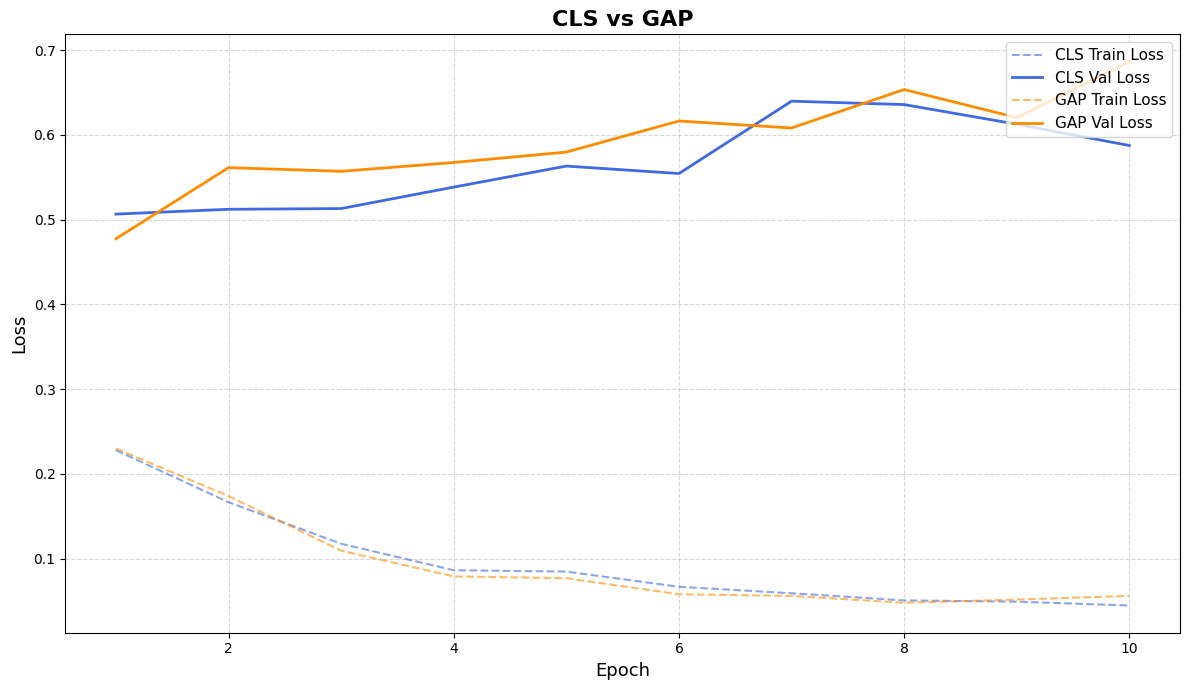

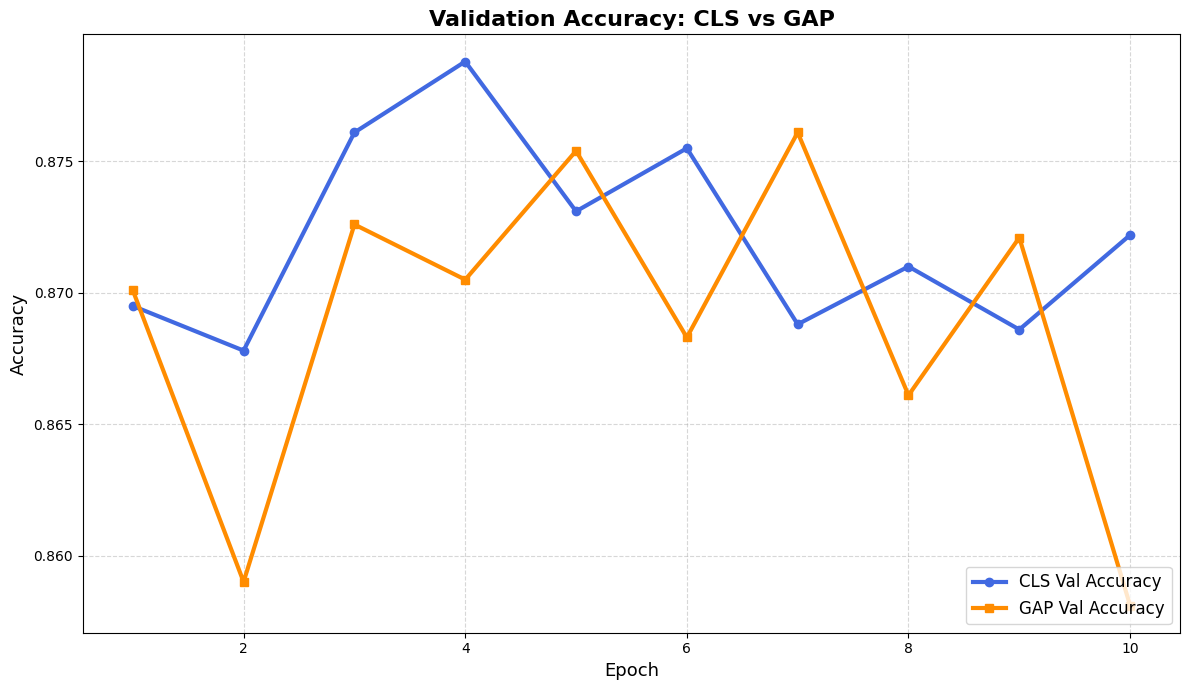

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기

df_cls = pd.read_csv('/content/drive/MyDrive/vit_compare_log/cls_training_log.csv')
df_gap = pd.read_csv('/content/drive/MyDrive/vit_compare_log/gap_training_log.csv')

# 2. Loss 비교 그래프
plt.figure(figsize=(12, 7))

# CLS 모델
plt.plot(df_cls['epoch'], df_cls['cls_train_loss'], label='CLS Train Loss', color='royalblue', linestyle='--', alpha=0.6)
plt.plot(df_cls['epoch'], df_cls['cls_val_loss'], label='CLS Val Loss', color='royalblue', linewidth=2)

# GAP 모델
plt.plot(df_gap['epoch'], df_gap['gap_train_loss'], label='GAP Train Loss', color='darkorange', linestyle='--', alpha=0.6)
plt.plot(df_gap['epoch'], df_gap['gap_val_loss'], label='GAP Val Loss', color='darkorange', linewidth=2)

plt.title('CLS vs GAP', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

# 저장 경로 (폴더가 있는지 확인하세요!)
plt.savefig('/content/drive/MyDrive/vit_compare_log/loss_comparison_plot.png')
plt.show()

# 3. Accuracy 비교 그래프 (Validation 중심)
plt.figure(figsize=(12, 7))

# CLS Val Accuracy
plt.plot(df_cls['epoch'], df_cls['cls_val_accuracy'], label='CLS Val Accuracy', color='royalblue', marker='o', linewidth=3)

# GAP Val Accuracy
plt.plot(df_gap['epoch'], df_gap['gap_val_accuracy'], label='GAP Val Accuracy', color='darkorange', marker='s', linewidth=3)

plt.title('Validation Accuracy: CLS vs GAP', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/vit_compare_log/accuracy_comparison_plot.png')
plt.show()

In [38]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 저장 경로 설정
save_dir = '/content/drive/MyDrive/vit_compare_log/attention_all_samples'
os.makedirs(save_dir, exist_ok=True)

def get_attention_map_tensor(model, img_tensor, mode='cls'):
    attentions = []
    def hook_fn(module, input, output):
        attentions.append(output)

    # 안전하게 attn_drop 대신 attn 모듈 자체에 걸어보겠습니다.
    target_layer = model.backbone.blocks[-1].attn
    handle = target_layer.register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        _ = model(img_tensor.to(device))
    handle.remove()

    # 가로챈 데이터가 튜플일 경우 (timm 특성) 처리
    attn_data = attentions[0]
    if isinstance(attn_data, tuple):
        # timm의 Attention은 보통 (output_tensor, weights)를 반환합니다.
        attn_data = attn_data[1]

    # [Batch, Heads, N, N] 형태인지 확인
    if attn_data.dim() == 4:
        # 헤드 평균 내서 [197, 197]로 만듦
        attn = attn_data[0].mean(dim=0).cpu().numpy()
    elif attn_data.dim() == 3:
        # [Heads, N, N]인 경우
        attn = attn_data.mean(dim=0).cpu().numpy()
    else:
        # 그 외의 경우 (이미 2차원일 때 등)
        attn = attn_data.cpu().numpy()

    # 이제 안전하게 슬라이싱
    try:
        if mode == 'cls':
            # 197개 중 CLS(0번)를 제외한 196개를 14x14로
            result = attn[0, 1:].reshape(14, 14)
        else:
            result = attn[1:, 1:].mean(axis=0).reshape(14, 14)
    except ValueError:
        # 혹시 패치 개수가 197이 아닐 경우(예: CLS가 없는 모델 등)를 위한 예외 처리
        side = int(np.sqrt(attn.shape[-1]))
        result = attn[-1, -side**2:].reshape(side, side)

    result = cv2.resize(result, (224, 224))
    result = (result - result.min()) / (result.max() - result.min() + 1e-8)
    return result

# 2. 32장 순차 저장 루프
print(f"이미지 생성 시작... 저장 경로: {save_dir}")

# DataLoader에서 데이터를 가져옵니다.
images, labels = next(iter(val_DL))

for i in tqdm(range(min(32, len(images)))):
    img_tensor = images[i].unsqueeze(0)
    label = labels[i].item()

    # 맵 생성 (CLS 모델과 GAP 모델 각각 실행)
    cls_map = get_attention_map_tensor(model_cls, img_tensor, mode='cls')
    gap_map = get_attention_map_tensor(model_gap, img_tensor, mode='gap')

    # 원본 이미지 복원 (역정규화)
    orig_img = images[i].permute(1, 2, 0).cpu().numpy()
    orig_img = (np.array([0.229, 0.224, 0.225]) * orig_img) + np.array([0.485, 0.456, 0.406])
    orig_img = np.clip(orig_img, 0, 1)

    # 그래프 그리기 및 저장
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original
    axes[0].imshow(orig_img)
    axes[0].set_title(f"Sample {i} (Label: {label})", fontsize=15)
    axes[0].axis('off')

    # CLS Focus
    axes[1].imshow(orig_img)
    axes[1].imshow(cls_map, cmap='jet', alpha=0.45)
    axes[1].set_title("CLS Attention Map", fontsize=15)
    axes[1].axis('off')

    # GAP Focus
    axes[2].imshow(orig_img)
    axes[2].imshow(gap_map, cmap='jet', alpha=0.45)
    axes[2].set_title("GAP Attention Map", fontsize=15)
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/all_sample_{i}.png', bbox_inches='tight')
    plt.close()

print(f"총 32장의 비교 이미지가 {save_dir}에 저장되었습니다.")

이미지 생성 시작... 저장 경로: /content/drive/MyDrive/vit_compare_log/attention_all_samples


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]

총 32장의 비교 이미지가 /content/drive/MyDrive/vit_compare_log/attention_all_samples에 저장되었습니다.
